In [3]:
import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf

from FyeldGenerator import generate_field

from resnet import ResNetSummary

In [29]:
def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        base = np.power(k, -alpha) * scale**2
        return base

    return power_spectrum


def distribution(shape=(128, 128)):
    a = np.random.normal(loc=0, scale=1., size=shape)
    b = np.random.normal(loc=0, scale=1., size=shape)
    return a + 1j * b

In [30]:
shape = (128, 128)
n_examples = 5
alphas = np.linspace(2, 5, n_examples)
spectra = [generate_power_spectrum(alpha, 1) for alpha in alphas]

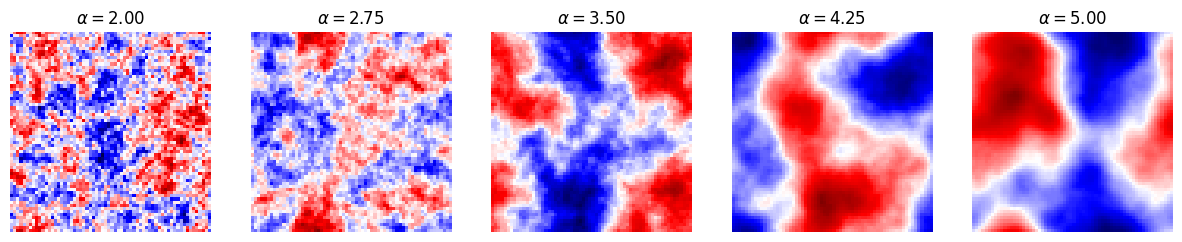

In [31]:
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 4))

for power_spectrum, alpha, ax in zip(spectra, alphas, axs):
    
    field = generate_field(distribution, power_spectrum, shape)
    max_magnitude = np.max(np.abs(field))
    ax.imshow(field, cmap="seismic", vmin=-max_magnitude, vmax=max_magnitude)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_axis_off()

In [41]:
rng = np.random.default_rng()


def prior():
    return {"log_std": rng.normal(scale=0.3), "alpha": rng.normal(loc=3, scale=0.5)}


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None]}


simulator = bf.make_simulator([prior, likelihood])

## Training

In [42]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(500)

In [60]:
summary_network = ResNetSummary(
    summary_dim=8, 
    widths=[16, 32], 
    use_batch_norm=False,
    dropout=0.0
)

inference_network = bf.networks.FlowMatching(subnet_kwargs={"widths": 3*(64,), "dropout": 0.2})

workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    summary_network=summary_network,
    inference_network=inference_network,
    inference_variables=["log_std", "alpha"],
    summary_variables=["field"],
    standardize="summary_variables",
)

In [61]:
workflow.approximator.summary()

Model: "continuous_approximator_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching_7 (FlowMatching)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_summary_7               │ ?                      │   0 (unbuilt) │
│ (ResNetSummary)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ standardization_7               │ ?                      │   0 (unbuilt) │
│ (Standardization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = workflow.fit_offline(
    data=training_data,
    epochs=100,
    validation_data=validation_data,
    batch_size=32,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.9839 - val_loss: 1.3304
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7007 - val_loss: 0.7459
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0102 - val_loss: 0.5793
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8552 - val_loss: 0.5787
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.7129 - val_loss: 0.5247
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6001 - val_loss: 0.4844
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5715 - val_loss: 0.4661
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5372 - val_loss: 0.4707
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4801 - val_loss: 0.3977
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4464 - val_loss: 0.4634
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4010 - val_loss: 0.3784
Epoch 12/100
157/157 ━━━━━━━━━

In [63]:
test_data = simulator.sample(100)

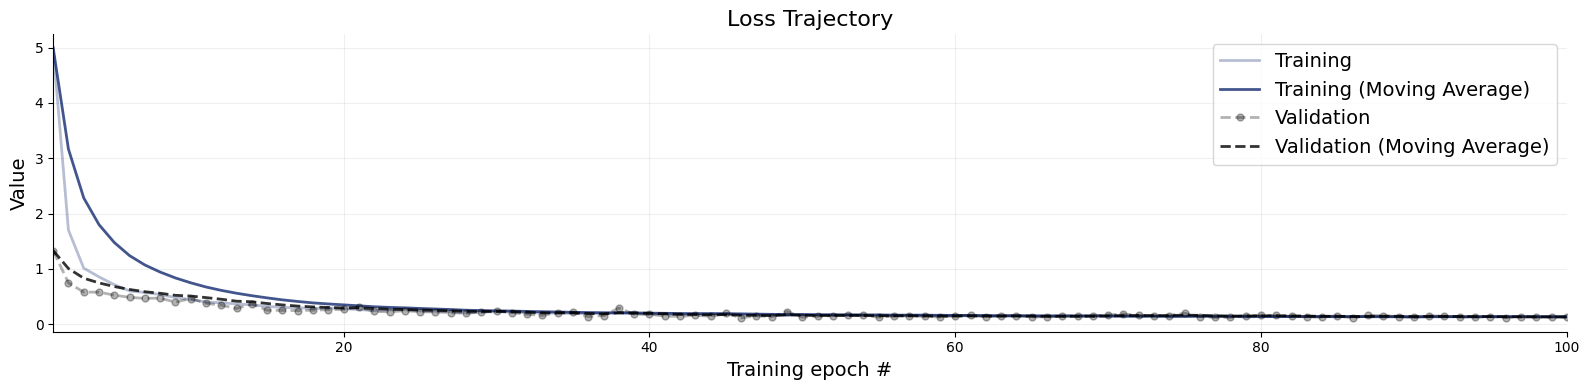

In [65]:
f = bf.diagnostics.plots.loss(history)

{'recovery': <Figure size 1000x500 with 2 Axes>,
 'calibration': <Figure size 1000x500 with 2 Axes>}

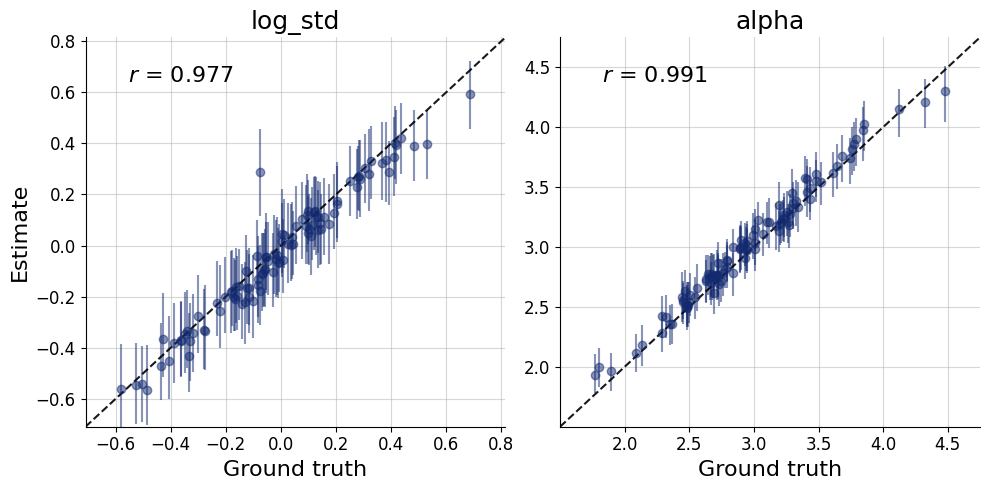

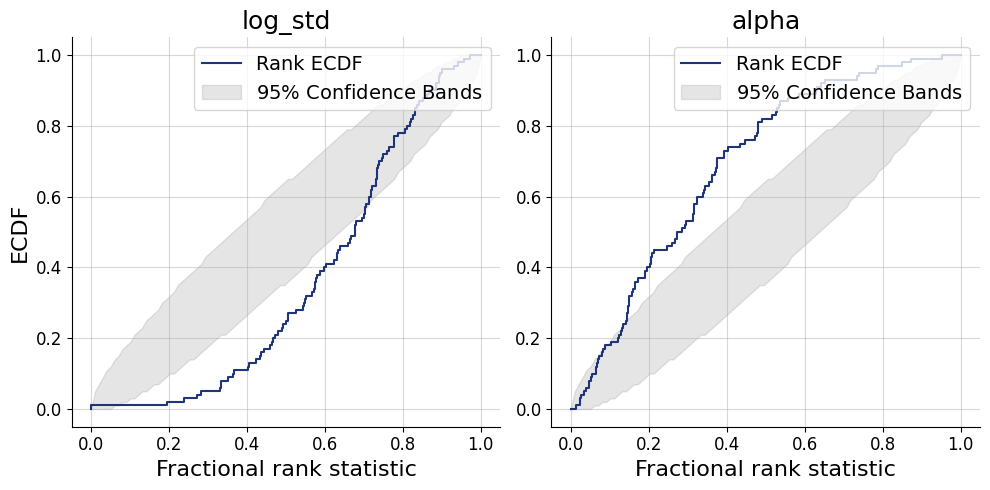

In [66]:
small_training_data = {k: v[:100] for k,v in training_data.items()}

workflow.plot_custom_diagnostics(
    test_data=test_data,
    plot_fns={
        "recovery": bf.diagnostics.recovery,
        "calibration": bf.diagnostics.calibration_ecdf,
    },
)